Business Understanding

Data Understaning

In [1]:
from genres import collect_genre_features

In [2]:
genre_playlists = {
    'bluegrass':'https://www.youtube.com/playlist?list=PLKUA473MWUv2mddNMPh-MJkgTR5AjTpl3',
    'blues':'https://www.youtube.com/playlist?list=PLxvodScTx2RuB7Yh_d21kD0HDZvDXWBbY',
    'folk':'https://www.youtube.com/playlist?list=PLGBuKfnErZlBLNzS_JlDAeiH5aW26rvHc',
    'classic_rock':'https://www.youtube.com/playlist?list=PLNxOe-buLm6cz8UQ-hyG1nm3RTNBUBv3K'
}
# collect_genre_features(genre_playlists, data_fp='data/extra_genre_features.json')

In [3]:
import pandas as pd

In [4]:
df_extra = pd.read_json('data/extra_genre_features.json', lines=True)

In [5]:
df_extra.groupby('genre').song.nunique()

genre
bluegrass       87
blues           92
classic_rock    80
folk            74
Name: song, dtype: int64

In [6]:
df_extra.groupby('genre').song.count()

genre
bluegrass       2083
blues           2206
classic_rock    1920
folk            1773
Name: song, dtype: int64

Not perfect but a reasonable chunk.

### Lets Pickle them for storage on git.

In [7]:
import pickle

In [8]:
with open('data/extra_genre_features.pkl', 'wb') as f:
    pickle.dump(df_extra.to_json(), f)

In [9]:
df_original = pd.read_json('data/genre_features.json', lines=True)

In [10]:
with open('data/genre_features.pkl', 'wb') as f:
    pickle.dump(df_original.to_json(), f)

### Data Preparation

Putting the old with the new.

In [11]:
with open('data/genre_features.pkl', 'rb') as f:
    df_original = pd.read_json(pickle.load(f))
with open('data/extra_genre_features.pkl', 'rb') as f:
    df_extra = pd.read_json(pickle.load(f))

In [19]:
df = pd.concat([df_original, df_extra])

In [23]:
from sklearn.model_selection import train_test_split

y = df['genre']
X = df.drop(['genre', 'song'], axis=1)
X_model, X_val, y_model, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=111,
    stratify=y
)
X_train, X_test, y_train, y_test = train_test_split(
    X_model,
    y_model,
    test_size=0.2,
    random_state=111,
    stratify=y_model
)

In [24]:
y.value_counts()

metal           2399
jazz            2397
country         2389
electronic      2371
hip_hop         2345
classical       2320
blues           2206
bluegrass       2083
classic_rock    1920
folk            1773
Name: genre, dtype: int64

In [36]:
tt_split_dists = pd.concat(
    [
        y_train.value_counts(sort=False),
        y_test.value_counts(sort=False),
        y_val.value_counts(sort=False)
    ],
    axis=1,
    sort=False
)
tt_split_dists

,genre,genre,genre
bluegrass,1333,333,417
metal,1535,384,480
hip_hop,1501,375,469
classical,1485,371,464
electronic,1517,380,474
jazz,1534,384,479
classic_rock,1229,307,384
country,1529,382,478
folk,1134,284,355
blues,1412,353,441


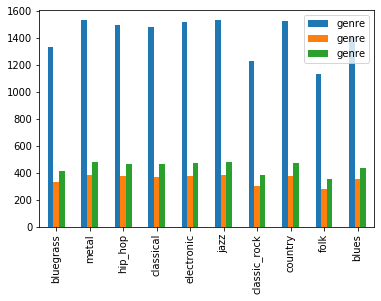

In [40]:
tt_split_dists.plot.bar();

Modeling

Evaluation

Deployment